(ML:tutorial:classification_demo)=
# Supervised learning with PyTorch: a toy example 


## Introduction

In this example, you will use a supervised learning strategy to train a neural network. The example is deliberately very simple to allow for great scalability and fast CPU learning. 



In [12]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import optimize
import numba
import torch
import tqdm
from IPython.display import YouTubeVideo

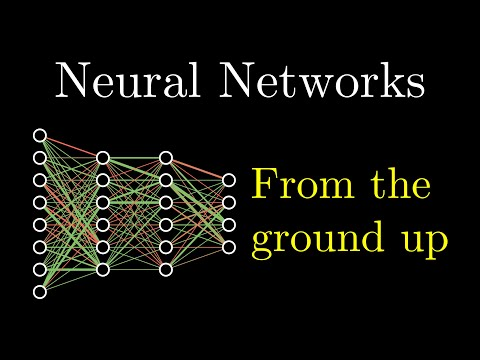

In [13]:
YouTubeVideo("aircAruvnKk")

## Exact model

In this first part, we propose to define an ideal classification model. It is a function which associates a value $z \in \left\lbrace 0, 1 \right \rbrace$ to a tuple of values $(x, y)$. This function represents categories that we would like to model the distribution in space. In a real case, this function would be inaccessible to us and we would try to find it through deep learning.

We propose two examples of functions but you are encouraged to develop your own and to test them.

In [14]:
def func_easy(inp):
    """
    A ideal model.
    """
    xc1, yc1 = 0.3, 0.6
    xc2, yc2 = 0.55, 0.15
    r1, r2 = 0.25, 0.15
    X, Y = np.array(inp).T
    R12 = (X - xc1) ** 2 + (Y - yc1) ** 2
    R22 = (X - xc2) ** 2 + (Y - yc2) ** 2
    return ((R22 <= r2**2) | (R12 <= r1**2)) * 1


def func_hard(inp):
    """
    Another ideal model.
    """
    x, y = np.array(inp).T - 0.5
    r = np.sqrt(x**2 + y**2)
    theta = np.arccos(x / r) * np.sign(y)
    out = (np.cos(3 * theta + 10 * r) >= 0.0) * 1
    out[r <= 0.1] = 1
    return out


exact_model = func_easy


In what follows, we draw the model to see what it looks like.

In [15]:
nxm, nym = 200, 200
xm = np.linspace(0, 1.0, nxm)
ym = np.linspace(0, 1.0, nym)
Xm, Ym = np.meshgrid(xm, ym)
pointsm = np.array([Xm.flatten(), Ym.flatten()]).T
solm = exact_model(pointsm)
solm


array([0, 0, 0, ..., 0, 0, 0])

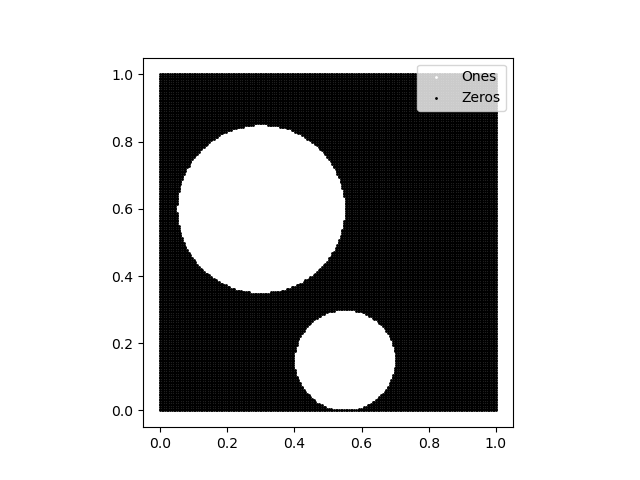

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")
plt.scatter(
    pointsm[solm == 1].T[0], pointsm[solm == 1].T[1], s=1, color="white", label="Ones"
)
plt.scatter(
    pointsm[solm == 0].T[0], pointsm[solm == 0].T[1], s=1, color="black", label="Zeros"
)
plt.legend()
plt.show()


## Learning DB

In [17]:
npl = 200000
pointsl = np.random.rand(npl * 2).reshape(npl, 2)
soll = exact_model(pointsl)


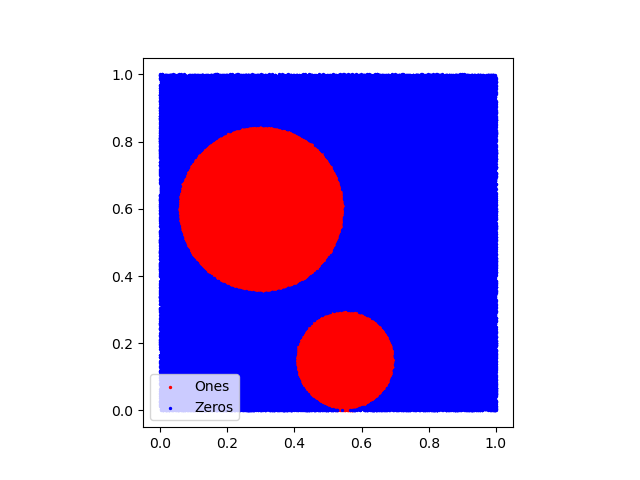

In [18]:
fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")
plt.scatter(
    pointsl[soll == 1].T[0], pointsl[soll == 1].T[1], s=2, color="red", label="Ones"
)
plt.scatter(
    pointsl[soll == 0].T[0], pointsl[soll == 0].T[1], s=2, color="blue", label="Zeros"
)
plt.legend()
plt.show()


## Neural Network class

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(device)


force_cpu = True
if force_cpu:
    device = torch.device("cpu")

print(f"Using {device} device {device_name}")

Using cpu device NVIDIA GeForce RTX 3090


In [20]:
device

device(type='cpu')

In [21]:
# BUILD LAYERS WITH:
# LINEAR LAYERS:
torch.nn.Linear(2, 4, bias=True)
# NEURAL FUNCTIONS:
torch.nn.ELU, torch.nn.ReLU, torch.nn.Hardtanh
activation_func = torch.nn.ELU

# LAYERS INITIALIZATION
layers = [
    torch.nn.Linear(2, 4, bias=True),
    activation_func(),
    torch.nn.Linear(4, 10, bias=True),
    activation_func(),
    torch.nn.Linear(10, 4, bias=True),
    activation_func(),
    torch.nn.Linear(4, 1, bias=True),
    torch.nn.Hardtanh(min_val=0.0, max_val=1.0),
]
model = torch.nn.Sequential(*layers).to(device)
layers


[Linear(in_features=2, out_features=4, bias=True),
 ELU(alpha=1.0),
 Linear(in_features=4, out_features=10, bias=True),
 ELU(alpha=1.0),
 Linear(in_features=10, out_features=4, bias=True),
 ELU(alpha=1.0),
 Linear(in_features=4, out_features=1, bias=True),
 Hardtanh(min_val=0.0, max_val=1.0)]

In [22]:
# TRAINING INPUTS / OUTPUTS
run_training = False
if run_training: # Put True to run training
    x = torch.Tensor(pointsl).to(device)
    t = torch.Tensor(soll[:, None]).to(device)
    ns = x.shape[0]
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="sum").to(device)
    Ne = 50 # Number of training epoch
    Nes = 100 # Number of training steps per epoch
    error = np.zeros(Ne)

    # TRAINING
    pbar = tqdm.trange(Ne)
    for e in pbar: 
        for s in range(Nes):
            y = model(x)
            loss = loss_fn(y, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        error[e] = loss.item() / ns
        err_str =  "{0:.3f}".format(error[e] * 100).zfill(6)
        pbar.set_description(f"Error = {err_str}")

      

In [23]:
# POST-PROCESSING
if run_training:
    fig = plt.figure()
    # plt.yscale("log")
    plt.plot(error * 100, "or-")
    plt.xlabel("Epoch")
    plt.ylabel("Loss [%]")
    plt.yscale("log")
    plt.grid()


In [24]:
if run_training:
    yt = model(torch.Tensor(pointsm).to(device)).cpu().data.numpy().ravel()
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.set_aspect("equal")
    plt.title("Model")
    plt.tricontourf(pointsm.T[0], pointsm.T[1], solm, 2, cmap=mpl.cm.gray)
    ax.axis("off")
    ax = fig.add_subplot(1, 3, 2)
    ax.set_aspect("equal")
    plt.title("Learned")
    plt.tricontourf(pointsm.T[0], pointsm.T[1], yt, cmap=mpl.cm.gray)
    ax.axis("off")
    ax = fig.add_subplot(1, 3, 3)
    ax.set_aspect("equal")
    plt.title("Error")
    plt.tricontourf(pointsm.T[0], pointsm.T[1], yt - solm, cmap=mpl.cm.gray)
    ax.axis("off")
    plt.show()
